In [ ]:
Link Dataset: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data

# Import Modules

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import math
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.regularizers import l2

# Import data from dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir dataset
!cp -r /content/drive/MyDrive/Image_Processing/melanoma_cancer_dataset dataset/

In [ ]:
# Define dataset directory
dataset_dir = './dataset/melanoma_cancer_dataset'

# Define train and test directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Print the directory structure
for root, dirs, files in os.walk(dataset_dir):
    print(f"Root: {root}, Subdirectories: {dirs}, Files: {len(files)}")


Root: ./dataset/melanoma_cancer_dataset, Subdirectories: ['train', 'test'], Files: 0
Root: ./dataset/melanoma_cancer_dataset/train, Subdirectories: ['benign', 'malignant'], Files: 0
Root: ./dataset/melanoma_cancer_dataset/train/benign, Subdirectories: [], Files: 5000
Root: ./dataset/melanoma_cancer_dataset/train/malignant, Subdirectories: [], Files: 4605
Root: ./dataset/melanoma_cancer_dataset/test, Subdirectories: ['benign', 'malignant'], Files: 0
Root: ./dataset/melanoma_cancer_dataset/test/benign, Subdirectories: [], Files: 500
Root: ./dataset/melanoma_cancer_dataset/test/malignant, Subdirectories: [], Files: 500


In [ ]:
train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')

file_paths = []
labels = []

# adding "benign" image paths and labels
for filename in os.listdir(train_benign_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        file_paths.append(os.path.join(train_benign_dir, filename))
        labels.append('benign')

# adding "malignant" image paths and labels
for filename in os.listdir(train_malignant_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        file_paths.append(os.path.join(train_malignant_dir, filename))
        labels.append('malignant')

# create DataFrame
train_df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

In [ ]:
test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')

file_paths = []
labels = []

# adding "benign" image paths and labels
for filename in os.listdir(test_benign_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        file_paths.append(os.path.join(test_benign_dir, filename))
        labels.append('benign')

# adding "malignant" image paths and labels
for filename in os.listdir(test_malignant_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        file_paths.append(os.path.join(test_malignant_dir, filename))
        labels.append('malignant')

# create DataFrame
test_df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

Split train data for validation data

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [ ]:
# Display summaries
print("--- Train DataFrame Summary ---")
print(f"Total train samples: {len(train_df)}")
print(f"Benign samples: {len(train_df[train_df['label'] == 'benign'])}")
print(f"Malignant samples: {len(train_df[train_df['label'] == 'malignant'])}")

print("\n--- Valid DataFrame Summary ---")
print(f"Total train samples: {len(val_df)}")
print(f"Benign samples: {len(val_df[val_df['label'] == 'benign'])}")
print(f"Malignant samples: {len(val_df[val_df['label'] == 'malignant'])}")

print("\n--- Test DataFrame Summary ---")
print(f"Total test samples: {len(test_df)}")
print(f"Benign samples: {len(test_df[test_df['label'] == 'benign'])}")
print(f"Malignant samples: {len(test_df[test_df['label'] == 'malignant'])}")

--- Train DataFrame Summary ---
Total train samples: 7684
Benign samples: 3969
Malignant samples: 3715

--- Valid DataFrame Summary ---
Total train samples: 1921
Benign samples: 1031
Malignant samples: 890

--- Test DataFrame Summary ---
Total test samples: 1000
Benign samples: 500
Malignant samples: 500


In [ ]:
# define function to display images from a DataFrame
def display_sample_images(df, label, num_images=5):
    # Filter DataFrame by the label
    label_df = df[df['label'] == label]


    sample_df = label_df.sample(num_images, random_state=1)


    plt.figure(figsize=(15, 5))

    for i, (index, row) in enumerate(sample_df.iterrows()):
        img = mpimg.imread(row['file_path'])
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)

    plt.show()

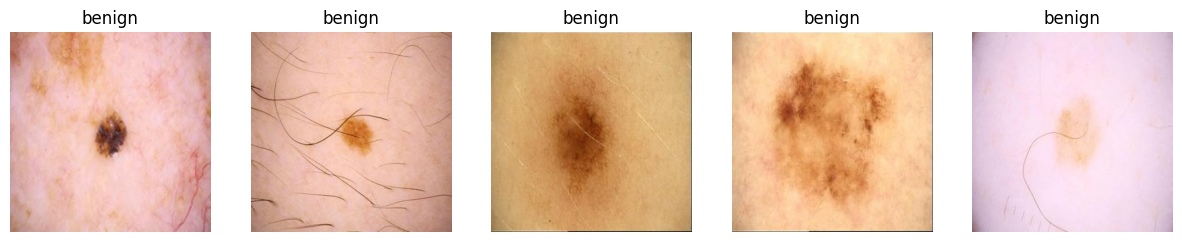

In [ ]:
display_sample_images(train_df, 'benign')

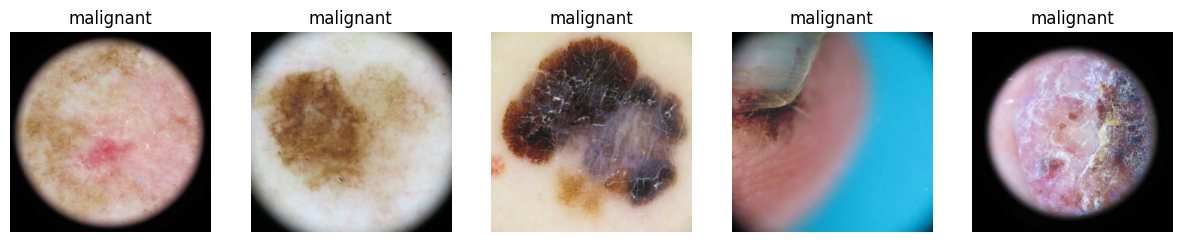

In [ ]:
display_sample_images(train_df, 'malignant')

# Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32
img_size = (224, 224)

train_gen = train_datagen.flow_from_dataframe( dataframe=train_df, x_col= 'file_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

val_gen = val_datagen.flow_from_dataframe( dataframe=val_df, x_col= 'file_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = test_datagen.flow_from_dataframe( dataframe=test_df, x_col= 'file_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 7684 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
# Display the first batch of images
image_batch, labels_batch = next(iter(train_gen))
first_image = image_batch[0]  # Get the first image from the batch

# Print min and max pixel values of the first image
print(f"Min pixel value: {np.min(first_image)}")
print(f"Max pixel value: {np.max(first_image)}")

Min pixel value: 0.12941177189350128
Max pixel value: 0.9411765336990356


In [ ]:
for image_batch, labels_batch in train_gen:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 2)


In [ ]:
# Calculate class weights
class_labels = train_df['label'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Map class weights to generator class indices
class_weight_dict = {
    train_gen.class_indices['benign']: class_weights[0],
    train_gen.class_indices['malignant']: class_weights[1]
}

print("Class Weights: ", class_weight_dict)


Class Weights:  {0: 0.9680020156210632, 1: 1.034185733512786}


# Build the model

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
epochs = 35

# Load the MobileNetV2 model with pre-trained weights, excluding the top fully connected layers
base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# Freeze the base model layers
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512,
          activation='relu',
          kernel_regularizer=l2(0.01)),  # Add L2 regularization to the dense layer
    Dropout(0.8),  # Add dropout for regularization
    Dense(class_count,
          activation='softmax',
          kernel_regularizer=l2(0.01))  # Add L2 regularization to the output layer
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


LR scheduler

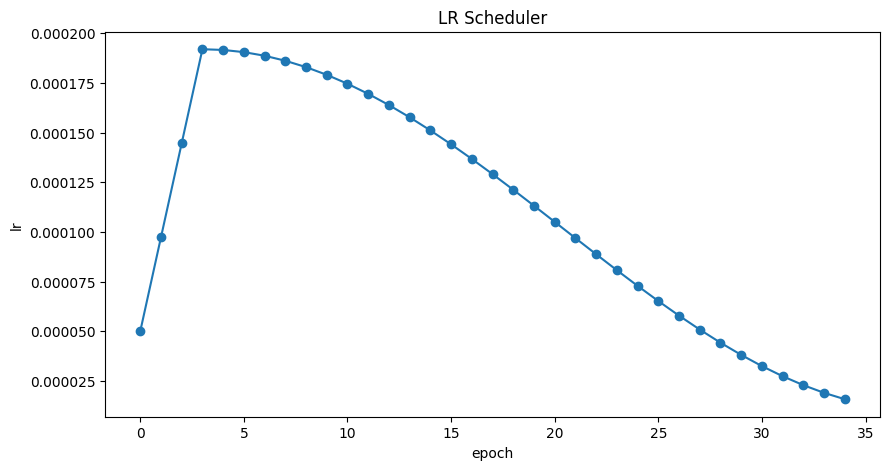

In [ ]:
lr_mode = 'cos'

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode=lr_mode, plot=True, epochs=epochs)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,920,002 (11.14 MB)

 Trainable params: 659,458 (2.52 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    validation_data=val_gen,
    callbacks=[early_stopping, lr_cb],
    class_weight=class_weight_dict
)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 - 43s - 177ms/step - accuracy: 0.7276 - loss: 7.8657 - val_accuracy: 0.8751 - val_loss: 6.9773 - learning_rate: 5.0000e-05
Epoch 2/35
241/241 - 19s - 80ms/step - accuracy: 0.8116 - loss: 6.6463 - val_accuracy: 0.8902 - val_loss: 5.8017 - learning_rate: 9.7333e-05
Epoch 3/35
241/241 - 19s - 78ms/step - accuracy: 0.8398 - loss: 5.3600 - val_accuracy: 0.8980 - val_loss: 4.6108 - learning_rate: 1.4467e-04
Epoch 4/35
241/241 - 17s - 70ms/step - accuracy: 0.8575 - loss: 4.1802 - val_accuracy: 0.9079 - val_loss: 3.5511 - learning_rate: 1.9200e-04
Epoch 5/35
241/241 - 17s - 69ms/step - accuracy: 0.8696 - loss: 3.2578 - val_accuracy: 0.9125 - val_loss: 2.8104 - learning_rate: 1.9163e-04
Epoch 6/35
241/241 - 19s - 79ms/step - accuracy: 0.8829 - loss: 2.5810 - val_accuracy: 0.9079 - val_loss: 2.2585 - learning_rate: 1.9054e-04
Epoch 7/35
241/241 - 19s - 77ms/step - accuracy: 0.8929 - loss: 2.0779 - val_accuracy: 0.9105 - val_loss: 1.8347 - learning_rate: 1.8872e-04
Epoch 8/35
241/241 - 20

# Evaluate the model

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


32/32 - 5s - 142ms/step - accuracy: 0.9090 - loss: 0.3438
Test Loss: 0.34381216764450073
Test Accuracy: 0.9089999794960022


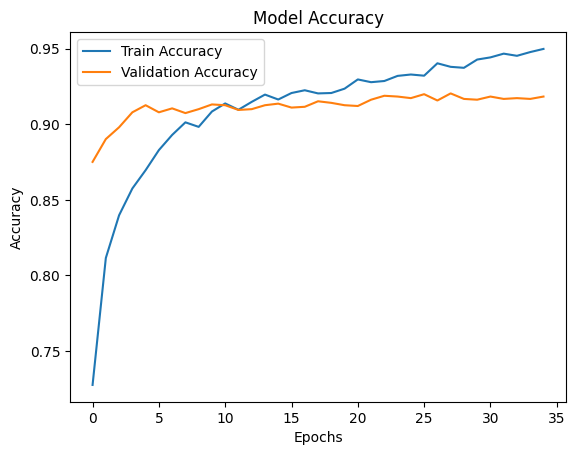

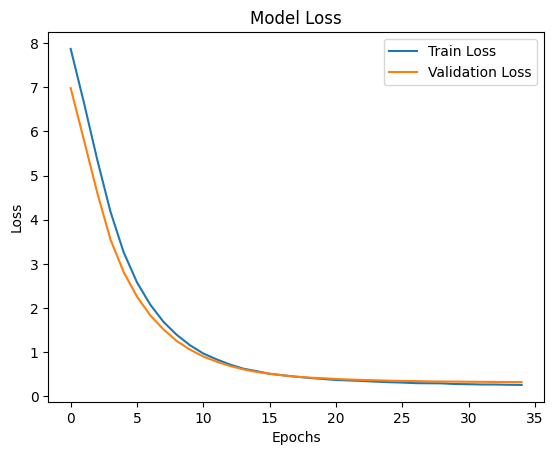

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('melanoma_model.h5')  # Save the model as an H5 file
model.save('my_model.keras')

In [ ]:
# Load the model
saved_model = load_model('my_model.keras')

# Evaluate the saved model
saved_model.evaluate(test_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9311 - loss: 0.3105


[0.34381216764450073, 0.9089999794960022]

Confusion Matrix

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step


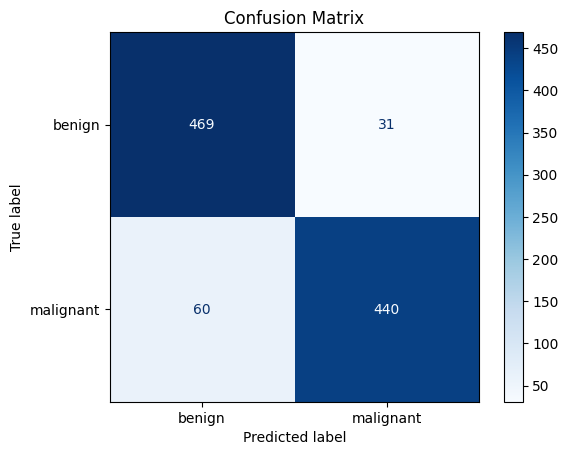

In [ ]:
# Get predictions for the test set
predictions = model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Classification report

In [ ]:
# Generate predictions
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

# Class labels
class_labels = list(test_gen.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.89      0.94      0.91       500
   malignant       0.93      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

